# Oscillation in eeg 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import scipy as sp

import mne 

warnings.filterwarnings('ignore')

Pas µV mais des mV 

Sampling rate = 250 Hz 

Filtre harr wavelet filter 

cut le sigal en plusieurs petites parties => 2 avant le gap 

durée totale aproximativement 1h30

In [3]:
sampling_rate = 250 # in seconds
time = 1/sampling_rate
unit_time = 's'

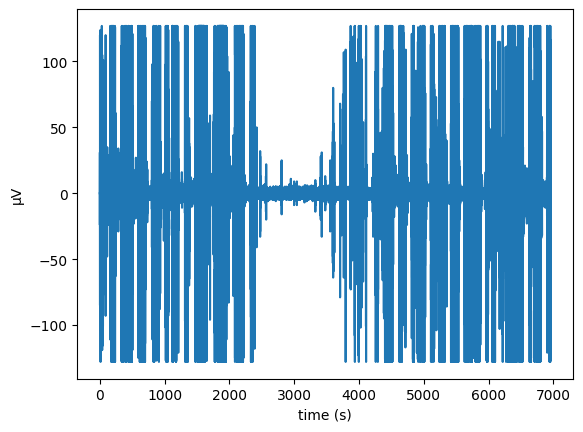

In [4]:
df = pd.read_csv('../../data/EEGArchi13mPFC.txt')
# df = df.iloc[int(start*20_000):int(end*20_000)] 
df['time'] = df.index * time
df.rename(columns={'0': 'µV'}, inplace=True)
plt.plot(df['time'], df['µV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('µV')
# plt.title('EEG signal on the first 3000 rows')
plt.savefig("./figures/EEG_signal_all_data.png")
plt.show()

## 1 Plot bruts datas 

### 1.1 Brut data on the first 10 minutes

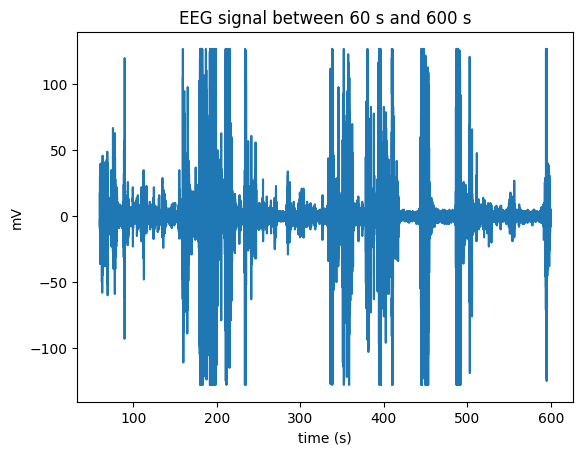

In [5]:
start = 60 # in seconds
end = 600 # in seconds 
df = pd.read_csv('../../data/EEGArchi13mPFC.txt')
df = df.iloc[int(start*sampling_rate):int(end*sampling_rate)] # Si on veut ne sélectionner qu'une partie du signal 
df['time'] = df.index * time
df.rename(columns={'0': 'mV'}, inplace=True)
plt.plot(df['time'], df['mV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('mV')
plt.title(f'EEG signal between {start} {unit_time} and {end} {unit_time}')
plt.savefig("./figures/EEG_signal_10_min_sample.png")
plt.show()

### 1.2 Plot with mne 

In [6]:
import numpy as np 
data = np.array([df['mV']])
info = mne.create_info(ch_names=['eeg'],
                       ch_types=['eeg'],
                       sfreq=sampling_rate)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot_psd()
plt.savefig('figures/mne_choice.png')

Creating RawArray with float64 data, n_channels=1, n_times=135000
    Range : 0 ... 134999 =      0.000 ...   539.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


### 1.3 Add choice phase data 

Choice data are considert after the gap 

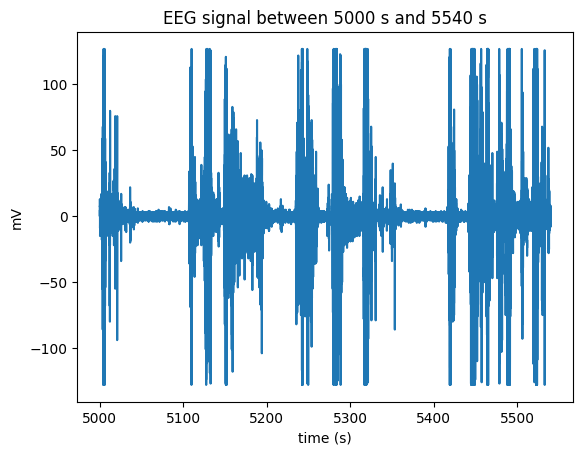

In [7]:
start = 5000 # in seconds
end = 5540 # in seconds 

df_choice = pd.read_csv('../../data/EEGArchi13mPFC.txt')
df_choice = df_choice.iloc[int(start*sampling_rate):int(end*sampling_rate)]
df_choice['time'] = df_choice.index * time
df_choice.rename(columns={'0': 'mV'}, inplace=True)
plt.close('all')
plt.plot(df_choice['time'], df_choice['mV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('mV')
plt.title(f'EEG signal between {start} {unit_time} and {end} {unit_time}')
plt.savefig('figures/EEG_signal_choice.png')
plt.show()

### 1.4 Plot bruts data with sample phase and chice phase

In [8]:
data = np.array([df['mV'], df_choice['mV']])
info = mne.create_info(
    ch_names=['eeg']*2,
    ch_types=['eeg']*2,
    sfreq=sampling_rate)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.compute_psd(method ='auto', fmin=0, fmax=120, n_fft=1000).plot()
plt.savefig('figures/mne_sample_choice.png')

Creating RawArray with float64 data, n_channels=2, n_times=135000
    Range : 0 ... 134999 =      0.000 ...   539.996 secs
Ready.
Effective window size : 4.000 (s)


Here we don't see big differences between the two phases of analysis (sample & choice)

We try to change the color but it doesn't work for the moment 

## 2 filtering 

### 2.1 Filter the data with Harr wavelet filter

In [9]:
def haarFWT ( signal, level ):
    """
    Compute the Haar Wavelet Transform of a signal
    
    Parameters
    ----------
    signal : array-like
        The signal to be transformed
    level : int
        The number of levels of the transform
    
    Returns
    -------
    array-like
        The transformed signal
    """

    s = .5   
    h = [ 1,  1 ] # lowpass filter
    g = [ 1, -1 ] # highpass filter        
    f = len( h ) # length of the filter

    t = signal # 'workspace' array
    l = len ( t ) # length of the current signal
    y = [0] * l  # output array
    t += [0,0]

    for i in range ( level ):
        y [ 0:l ] = [0] * l  
        l2 = l // 2 
        for j in range ( l2 ):            
            for k in range ( f ):                
                y [j] += t [ 2*j + k ] * h [ k ] * s
                y [j+l2] += t [ 2*j + k ] * g [ k ] * s
        l = l2 
        t [ 0:l ] = y [ 0:l ] 
    return y

df['haar'] = haarFWT(list(df['mV']), 1)
df_choice['haar'] = haarFWT(list(df_choice['mV']), 1)

data = np.array([df['haar'], df_choice['haar']])
info = mne.create_info(
    ch_names=['eeg-0', 'eeg-1'],
    ch_types=['eeg']*2,
    sfreq=sampling_rate)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.compute_psd(method ='auto', fmin=0, fmax = 125, n_fft=1000).plot()
plt.savefig('figures/mne_haar_sample_choice.png')

Creating RawArray with float64 data, n_channels=2, n_times=135000
    Range : 0 ... 134999 =      0.000 ...   539.996 secs
Ready.
Effective window size : 4.000 (s)


Thanks to Haar wavelet we reduce the gap on 50 Hz. 

but we get a gap at 100 Hz

In [10]:
simulated_raw

<RawArray | 2 x 135000 (540.0 s), ~2.1 MB, data loaded>

## 3 Fourrier transform 

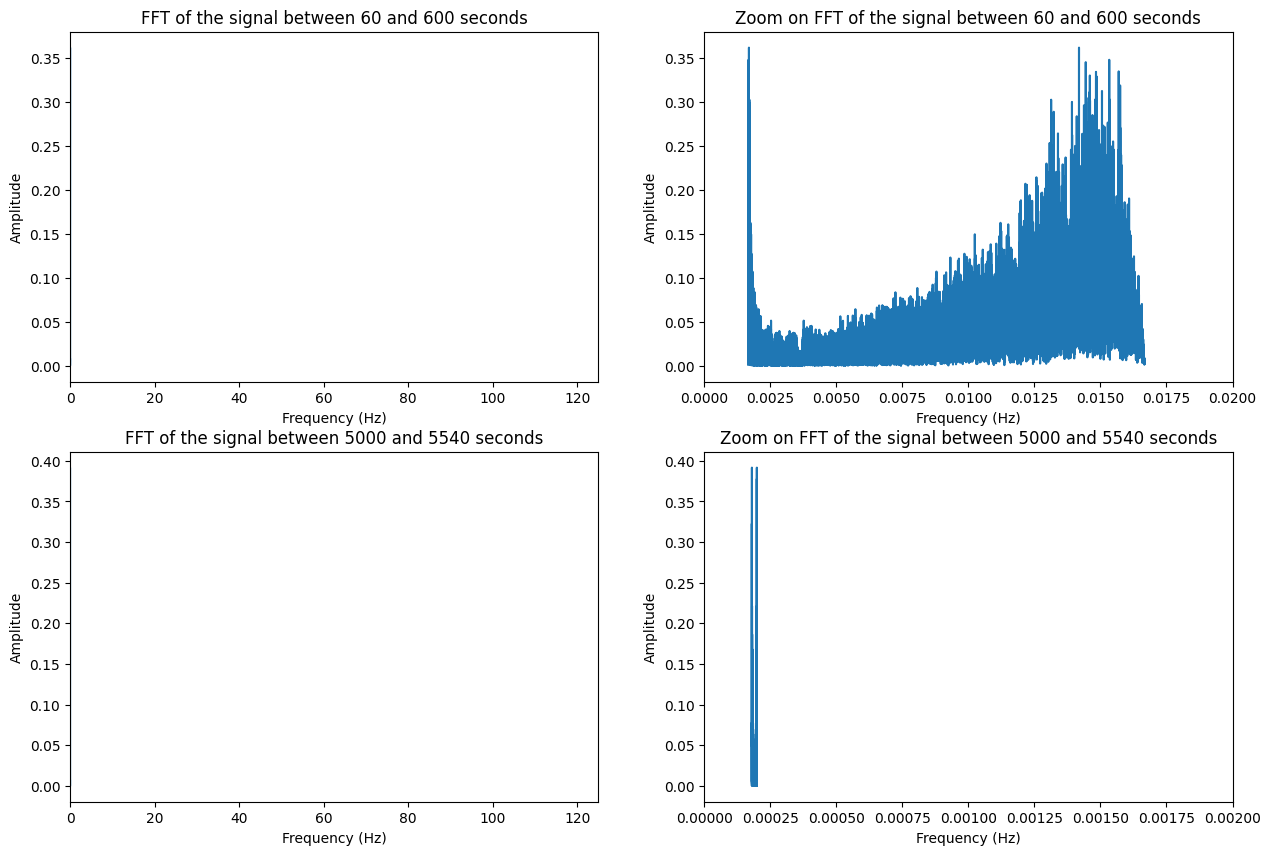

In [11]:
import scipy as sp 
import numpy as np
plt.close('all')

df_f = df.copy()
df_f['amplitude'] = sp.fftpack.fft(df_f['haar'].values)/len(df_f['haar'])
df_f["freq"] = 1/df_f['time']

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(df_f['freq'], np.abs(df_f['amplitude']))
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('FFT of the signal between 60 and 600 seconds')
ax[0,0].set_xlim(0, 125)

ax[0,1].plot(df_f['freq'], np.abs(df_f['amplitude']))
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_title('Zoom on FFT of the signal between 60 and 600 seconds')
ax[0,1].set_xlim(0, 0.02)

df_f = df_choice.copy()
df_f['amplitude'] = sp.fftpack.fft(df_f['haar'].values)/len(df_f['haar'])
df_f["freq"] = 1/df_f['time']

ax[1,0].plot(df_f['freq'], np.abs(df_f['amplitude']))
ax[1,0].set_xlabel('Frequency (Hz)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_title('FFT of the signal between 5000 and 5540 seconds')
ax[1,0].set_xlim(0, 125)

ax[1,1].plot(df_f['freq'], np.abs(df_f['amplitude']))
ax[1,1].set_xlabel('Frequency (Hz)')
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_title('Zoom on FFT of the signal between 5000 and 5540 seconds')
ax[1,1].set_xlim(0, 0.002)

plt.show()

It's strange, we have value just for very low frequency

Seem to be good for the signal between 5000 and 5540 sec, but not for the 60-600 sec 

In any case these results are not consistent because there is no peak for the different types of waves. 